<a href="https://colab.research.google.com/github/Aaryaveerkrishna23/churn_prediction_chaid/blob/main/CHAID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports


In [116]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
df = pd.read_csv("/content/churn.csv")

In [ ]:
!pip install CHAID[graph] CHAID

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.5 MB/s eta 0:00:00


## Selecting Features for chaid analysis

In [ ]:
selected_features = ['PaymentMethod', 'PaperlessBilling','InternetService','MonthlyCharges', 'TotalCharges' , 'InternetService','Contract','TechSupport']
X = df[selected_features]
y = df['Churn']

In [ ]:
X_train , X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
sampled_df = df.sample(n=2000, random_state=42)
len(sampled_df)

2000

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

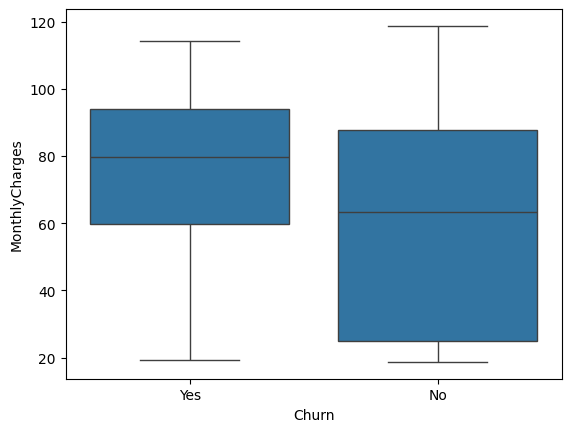

In [ ]:
sns.boxplot(x="Churn", y="MonthlyCharges", data=sampled_df)

## Visualizing the TotalCharges Distribution independent Variable

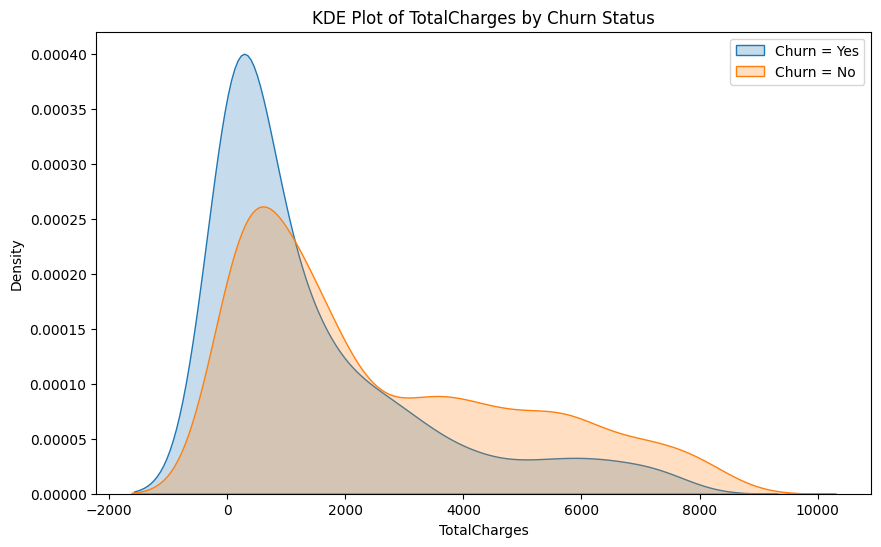

In [ ]:
sampled_df['TotalCharges'] = pd.to_numeric(sampled_df['TotalCharges'], errors='coerce')
sampled_df = sampled_df.dropna(subset=['TotalCharges'])
plt.figure(figsize=(10, 6))
sns.kdeplot(data=sampled_df[sampled_df['Churn'] == 'Yes'], x='TotalCharges', label='Churn = Yes', fill=True)
sns.kdeplot(data=sampled_df[sampled_df['Churn'] == 'No'], x='TotalCharges', label='Churn = No', fill=True)

plt.title("KDE Plot of TotalCharges by Churn Status")
plt.xlabel("TotalCharges")
plt.ylabel("Density")
plt.legend()
plt.show()

## Visualizing the MonthlyCharges Distribution independent Variable

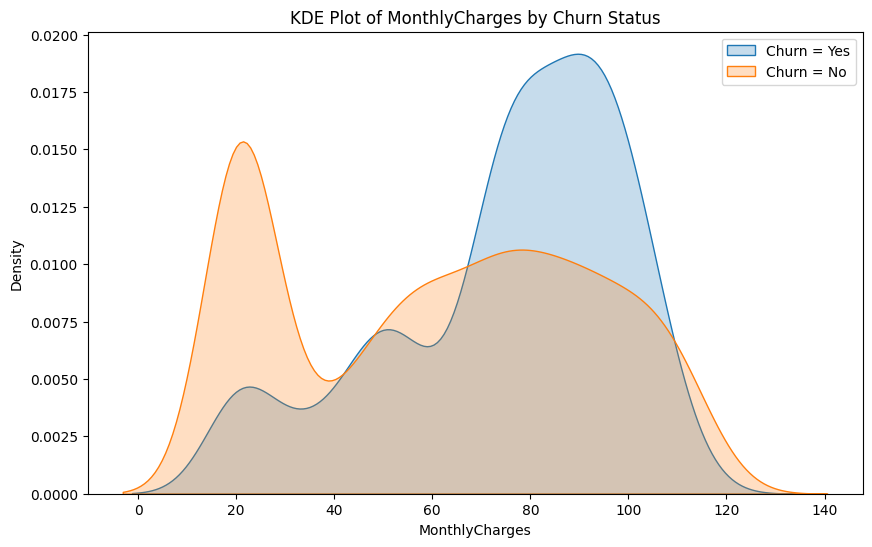

In [ ]:
sampled_df['TotalCharges'] = pd.to_numeric(sampled_df['TotalCharges'], errors='coerce')
sampled_df = sampled_df.dropna(subset=['TotalCharges'])
features = ['TotalCharges', 'MonthlyCharges', 'tenure']
sampled_df_pair = sampled_df[features + ['Churn']]
plt.figure(figsize=(10, 6))
sns.kdeplot(data=sampled_df[sampled_df['Churn'] == 'Yes'], x='MonthlyCharges', label='Churn = Yes', fill=True)
sns.kdeplot(data=sampled_df[sampled_df['Churn'] == 'No'], x='MonthlyCharges', label='Churn = No', fill=True)

plt.title("KDE Plot of MonthlyCharges by Churn Status")
plt.xlabel("MonthlyCharges")
plt.ylabel("Density")
plt.legend()
plt.show()

##### **Since most of the data for the monthly charges variable related to customer churn lies between 70 and 90, we label that range as 'More Likely to Churn'**

In [ ]:
try_df = sampled_df.copy()

In [ ]:
try_df['MonthlyCharges'] = try_df['MonthlyCharges'].between(70,90).map({True: "More_Likely_to_Churn", False: "Less_Likely_to_Churn"})
try_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
185,1024-GUALD,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,Less_Likely_to_Churn,24.80,Yes
2715,0484-JPBRU,Male,0,No,No,41,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),Less_Likely_to_Churn,996.45,No
3825,3620-EHIMZ,Female,0,Yes,Yes,52,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,Less_Likely_to_Churn,1031.70,No
1807,6910-HADCM,Female,0,No,No,1,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,No,Electronic check,More_Likely_to_Churn,76.35,Yes
132,8587-XYZSF,Male,0,No,No,67,Yes,No,DSL,No,...,No,Yes,No,No,Two year,No,Bank transfer (automatic),Less_Likely_to_Churn,3260.10,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3528,2332-EFBJY,Male,0,No,No,16,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,Less_Likely_to_Churn,342.40,Yes
2944,5311-IHLEI,Male,0,No,No,12,No,No phone service,DSL,Yes,...,No,Yes,Yes,No,Month-to-month,Yes,Bank transfer (automatic),Less_Likely_to_Churn,605.75,No
6878,2990-HWIML,Female,0,No,No,6,Yes,No,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,More_Likely_to_Churn,573.30,Yes
3734,7134-HBPBS,Female,1,No,No,72,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),Less_Likely_to_Churn,7774.05,No


<Axes: xlabel='MonthlyCharges', ylabel='Count'>

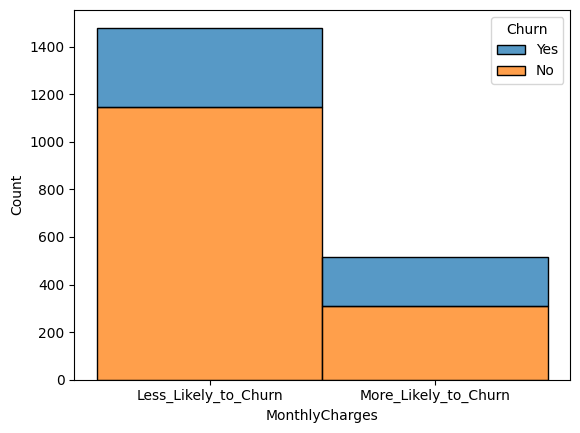

In [ ]:
sns.histplot(data=try_df, x='MonthlyCharges', hue='Churn', multiple='stack')

#### **Since the total charge range lying between 1,500 and 10,000 indicates a lower likelihood of churn and suggests greater investment, we label these customers as 'Premium Customers.**

In [ ]:
try_df['TotalCharges'] = try_df['TotalCharges'].between(1500,10000).map({True: "Premium_customer", False: "non_premium_customer"})
try_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
185,1024-GUALD,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,Less_Likely_to_Churn,non_premium_customer,Yes
2715,0484-JPBRU,Male,0,No,No,41,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),Less_Likely_to_Churn,non_premium_customer,No
3825,3620-EHIMZ,Female,0,Yes,Yes,52,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,Less_Likely_to_Churn,non_premium_customer,No
1807,6910-HADCM,Female,0,No,No,1,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,No,Electronic check,More_Likely_to_Churn,non_premium_customer,Yes
132,8587-XYZSF,Male,0,No,No,67,Yes,No,DSL,No,...,No,Yes,No,No,Two year,No,Bank transfer (automatic),Less_Likely_to_Churn,Premium_customer,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3528,2332-EFBJY,Male,0,No,No,16,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,Less_Likely_to_Churn,non_premium_customer,Yes
2944,5311-IHLEI,Male,0,No,No,12,No,No phone service,DSL,Yes,...,No,Yes,Yes,No,Month-to-month,Yes,Bank transfer (automatic),Less_Likely_to_Churn,non_premium_customer,No
6878,2990-HWIML,Female,0,No,No,6,Yes,No,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,More_Likely_to_Churn,non_premium_customer,Yes
3734,7134-HBPBS,Female,1,No,No,72,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),Less_Likely_to_Churn,Premium_customer,No


<Axes: xlabel='TotalCharges', ylabel='Count'>

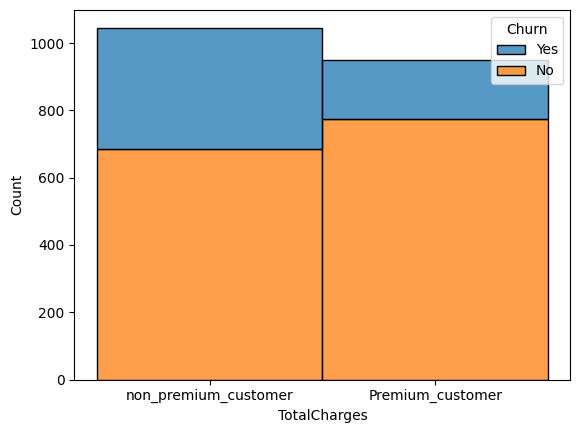

In [ ]:
sns.histplot(data=try_df, x='TotalCharges', hue='Churn', multiple='stack')

In [ ]:
try_df.to_csv('cleaned_data_churn.csv', index=True) #saving the data for visualizing in spss

In [ ]:
sum(sampled_df['Churn']=='No')

1460

# Implementing chaid!!

In [ ]:
from CHAID import Tree, NominalColumn
import pandas as pd
import numpy as np

# Define the dependent (target) variable
dep_variable = 'Churn'

# Build the tree using from_pandas_df method
tree = Tree.from_pandas_df(
    try_df[selected_features + ['Churn']],  # Select features and target
    dict(zip(selected_features, ['nominal'] * 10)),  # Specify feature types (nominal)
    dep_variable,
    dep_variable_type='categorical',
    max_depth=6,  # Set maximum depth for the tree
    alpha_merge=0.05  # Set alpha merge threshold
)
tree.print_tree()

b"([], {'No': 1457.0, 'Yes': 540.0}, (Contract, p=1.316100685522302e-79, score=363.25909801559516, groups=[['Month-to-month'], ['One year'], ['Two year']]), dof=2))\n|-- (['Month-to-month'], {'No': 626.0, 'Yes': 488.0}, (InternetService, p=1.1383461098837573e-23, score=105.6597614213236, groups=[['DSL'], ['Fiber optic'], ['No']]), dof=2))\n|   |-- (['DSL'], {'No': 240.0, 'Yes': 108.0}, (TotalCharges, p=0.0002410789052771434, score=13.480318274478858, groups=[['Premium_customer'], ['non_premium_customer']]), dof=1))\n|   |   |-- (['Premium_customer'], {'No': 64.0, 'Yes': 10.0}, (PaymentMethod, p=0.027950868515429935, score=4.8310952738184545, groups=[['Bank transfer (automatic)', 'Mailed check'], ['Credit card (automatic)', 'Electronic check']]), dof=1))\n|   |   |   |-- (['Bank transfer (automatic)', 'Mailed check'], {'No': 30.0, 'Yes': 1.0}, <Invalid Chaid Split> - the node only contains single category respondents)\n|   |   |   +-- (['Credit card (automatic)', 'Electronic check'], {'

In [ ]:
tree.to_tree().to_graphviz()

digraph tree {
	"0" [label="([], {'No': 1457.0, 'Yes': 540.0}, (Contract, p=1.316100685522302e-79, score=363.25909801559516, groups=[['Month-to-month'], ['One year'], ['Two year']]), dof=2))", shape=circle]
	"1" [label="(['Month-to-month'], {'No': 626.0, 'Yes': 488.0}, (InternetService, p=1.1383461098837573e-23, score=105.6597614213236, groups=[['DSL'], ['Fiber optic'], ['No']]), dof=2))", shape=circle]
	"17" [label="(['One year'], {'No': 360.0, 'Yes': 37.0}, (InternetService, p=0.0003111123394981897, score=13.002277536656596, groups=[['DSL', 'No'], ['Fiber optic']]), dof=1))", shape=circle]
	"20" [label="(['Two year'], {'No': 471.0, 'Yes': 15.0}, (PaymentMethod, p=0.004706808839344288, score=7.988781251425769, groups=[['Bank transfer (automatic)', 'Credit card (automatic)', 'Mailed check'], ['Electronic check']]), dof=1))", shape=circle]
	"2" [label="(['DSL'], {'No': 240.0, 'Yes': 108.0}, (TotalCharges, p=0.0002410789052771434, score=13.480318274478858, groups=[['Premium_customer'], [

#Chaid Accuracy

In [ ]:
tree.accuracy()

0.7921882824236355

#Additionally, testing the data using a decision tree and a random forest classifier and Cat boost

In [117]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [118]:
df_copy = df.copy()
df_copy

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


#Cleaning the data

In [ ]:
#STripping of white spaces from column names
df_one=df_copy.columns.str.replace(' ','')
df_one

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
df_copy.columns[df_copy.columns.str.contains('Pa|On',regex=True)] #Techniques to find out a pattern in columns

Index(['Partner', 'OnlineSecurity', 'OnlineBackup', 'PaperlessBilling',
       'PaymentMethod'],
      dtype='object')

In [ ]:
df.shape

(7043, 21)

In [ ]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

#Selecting independent parameters that have a stronger association with the dependent variable, i.e. Churn using chi2 values which is a non paramteric test for nominal data.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
X = df.iloc[:,1:20]  #independent columns
y = df['Churn']    #target column i.e price range
X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6


In [ ]:
df[df.isna().any(axis=1)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [ ]:
df['customerID'] = range(1, len(df) + 1)
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,2,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,4,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,5,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7039,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,7040,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,7041,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,7042,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


#Plotting Visulaizations!

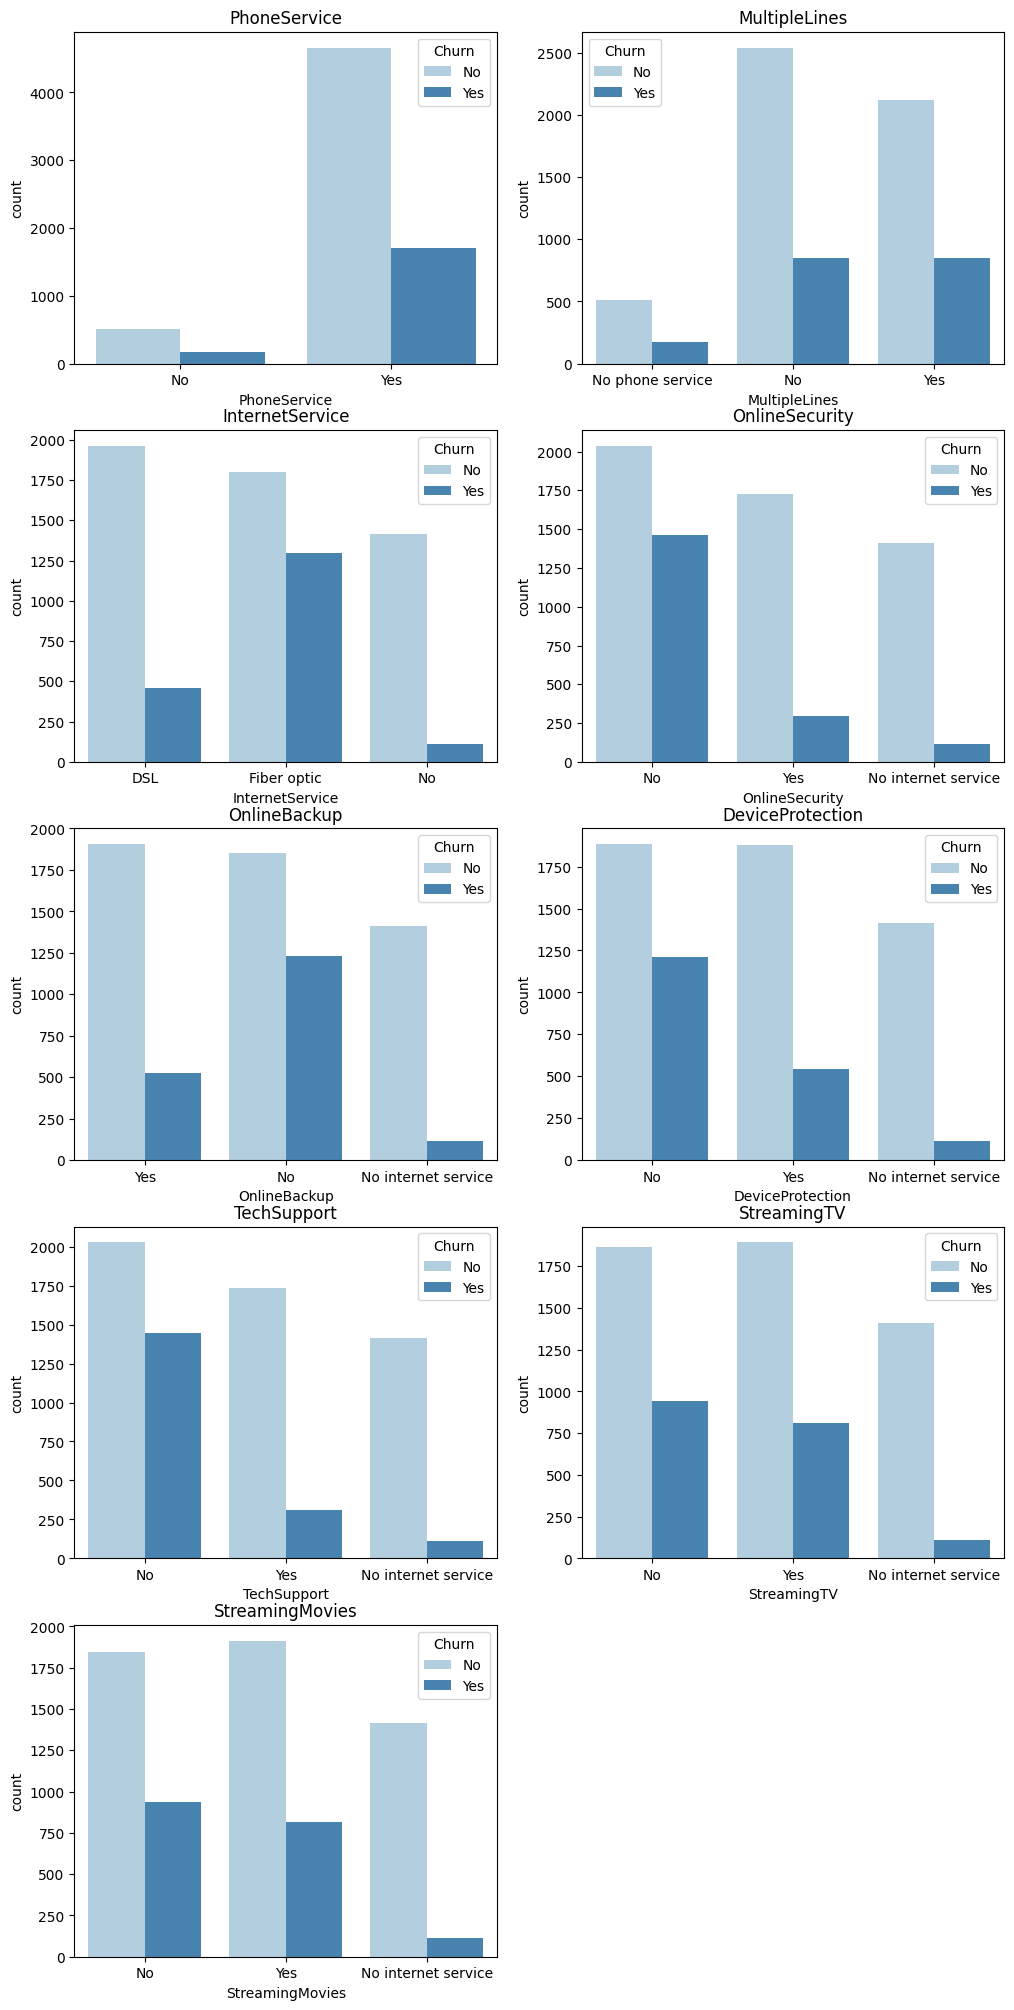

In [ ]:
import math
import matplotlib.pyplot as plt

def plot_categorical_to_target(df,categorical_values, target):
    number_of_columns = 2
    number_of_rows = (len(categorical_values)//2)

    fig = plt.figure(figsize = (12, 5*number_of_rows))

    for index, column in enumerate(categorical_values, 1):
        ax = fig.add_subplot(number_of_rows,number_of_columns,index)
        ax = sns.countplot(x = column, data = df, hue = target, palette="Blues")
        ax.set_title(column)
    return plt.show()
customer_services = ["PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup",
                    "DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
plot_categorical_to_target(df,customer_services, "Churn")

<Axes: xlabel='Churn', ylabel='count'>

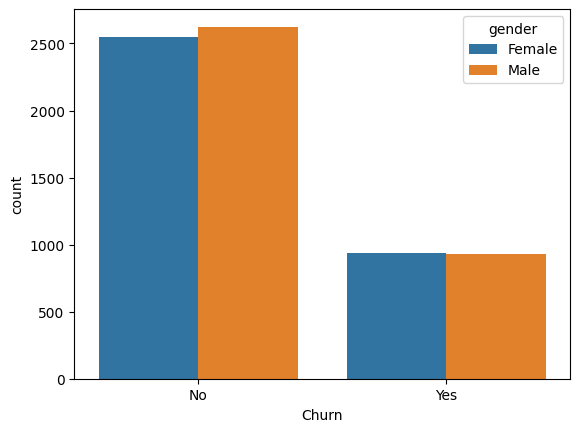

In [ ]:
sns.countplot(df, x="Churn", hue="gender")

In [ ]:
import math
import matplotlib.pyplot as plt

def plot_categorical_to_target(df,categorical_values, target):
    number_of_columns = 2
    number_of_rows = math.ceil(len(categorical_values)/2)

    fig = plt.figure(figsize = (12, 5*number_of_rows))

    for index, column in enumerate(categorical_values, 1):
        ax = fig.add_subplot(number_of_rows,number_of_columns,index)
        ax = sns.countplot(x = column, data = df, hue = target, palette="Blues")
        ax.set_title(column)
    return plt.show()

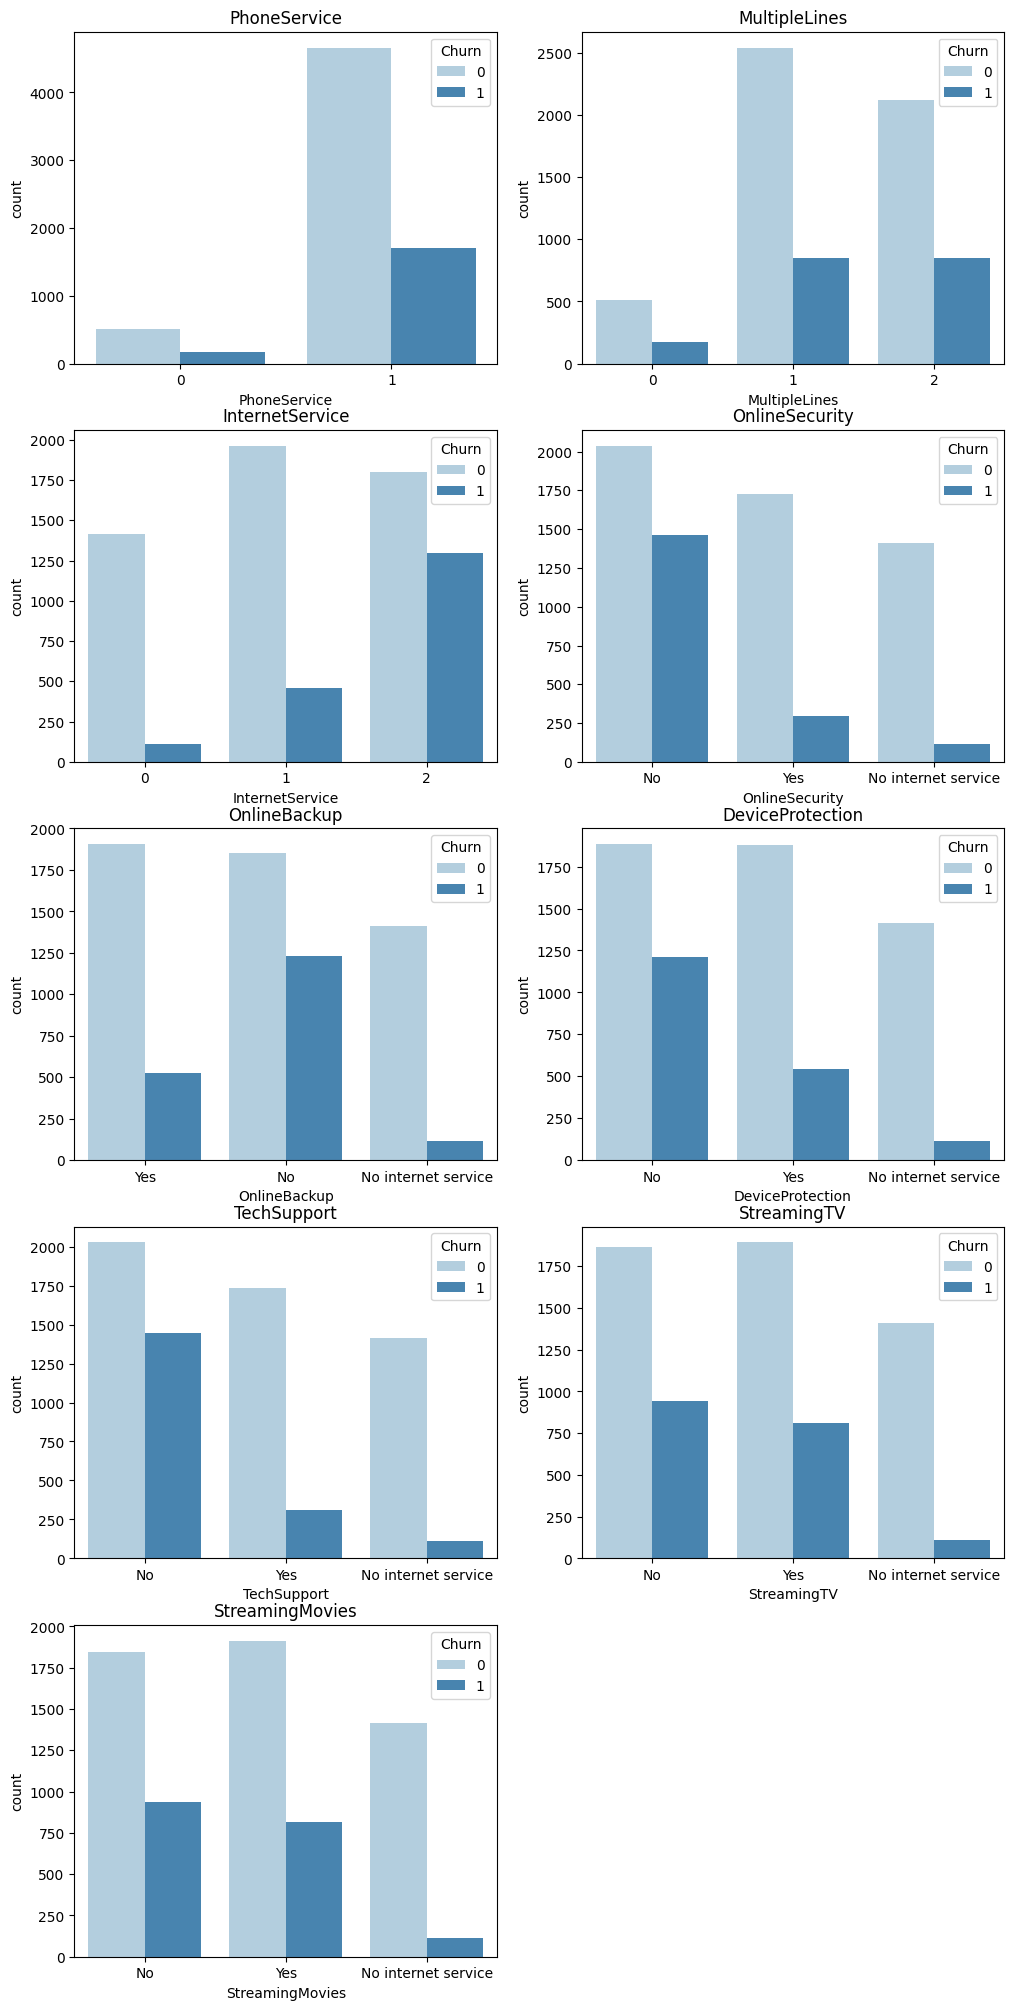

In [ ]:
customer_services = ["PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup",
                    "DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
plot_categorical_to_target(df,customer_services, "Churn")

#One hot encoding or labeled encoding were not apt , thus manually encoded the columns :)

In [127]:
df['PaymentMethod'] = df['PaymentMethod'].astype(str).str.replace(' ', '', regex=False)

In [119]:
df["MultipleLines"] = df["MultipleLines"].map({"No phone service": 0,"No" : 1,"Yes" :2})
df['InternetService'] = df['InternetService'].map({'DSL': 1, 'Fiber optic': 2, 'No': 0})
df['Contract'] = df['Contract'].map({'Month-to-month': 1, 'One year': 2, 'Two year': 3})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
df['PaymentMethod'] = df['PaymentMethod'].map({'Electronic check': 1, 'Mailed check': 2, 'Bank transfer (automatic)': 3, 'Credit card (automatic)': 4})
df['TechSupport'] = df['TechSupport'].map({'Yes': 1, 'No': 0})
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['MonthlyCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df['PhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})

In [129]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,Yes,No,1,0,0,1,No,...,No,0.0,No,No,1,1,1,29.85,29.85,0
1,5575-GNVDE,1,0,No,No,34,1,1,1,Yes,...,Yes,0.0,No,No,2,0,2,1889.50,1889.50,0
2,3668-QPYBK,1,0,No,No,2,1,1,1,Yes,...,No,0.0,No,No,1,1,2,108.15,108.15,1
3,7795-CFOCW,1,0,No,No,45,0,0,1,Yes,...,Yes,1.0,No,No,2,0,3,1840.75,1840.75,0
4,9237-HQITU,0,0,No,No,2,1,1,2,No,...,No,0.0,No,No,1,1,1,151.65,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1,0,Yes,Yes,24,1,2,1,Yes,...,Yes,1.0,Yes,Yes,2,1,2,1990.50,1990.50,0
7039,2234-XADUH,0,0,Yes,Yes,72,1,2,2,No,...,Yes,0.0,Yes,Yes,2,1,4,7362.90,7362.90,0
7040,4801-JZAZL,0,0,Yes,Yes,11,0,0,1,Yes,...,No,0.0,No,No,1,1,1,346.45,346.45,0
7041,8361-LTMKD,1,1,Yes,No,4,1,2,2,No,...,No,0.0,No,No,1,1,2,306.60,306.60,1


<Axes: >

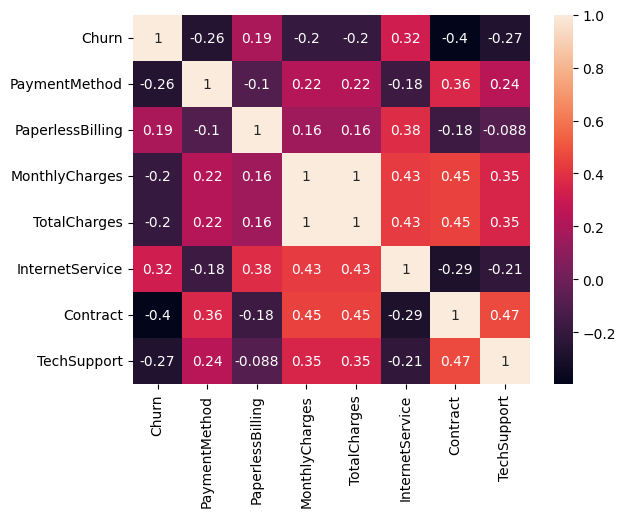

In [120]:
sns.heatmap(df[['Churn' , 'PaymentMethod', 'PaperlessBilling','MonthlyCharges', 'TotalCharges' , 'InternetService','Contract' ,'TechSupport']].corr(), annot=True)

Performing PCA to reduce the dimensionality of the independent features

In [121]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [145]:
num_variable_col = ['PaymentMethod', 'PaperlessBilling','MonthlyCharges', 'TotalCharges' , 'InternetService','Contract','TechSupport','gender','PhoneService','MultipleLines']

In [146]:
df.dropna(inplace=True)

In [161]:
X= df[num_variable_col]
y= df['Churn']
X.isna().sum()

,0
PaymentMethod,0
PaperlessBilling,0
MonthlyCharges,0
TotalCharges,0
InternetService,0
Contract,0
TechSupport,0
gender,0
PhoneService,0
MultipleLines,0


#Testing Decison tree , Random Forest and cat boost classifier using grid search cv in a pipeline function.

In [172]:
# Define the pipeline steps
pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),  # PCA without specified components; tuning will handle this
    ('dt', DecisionTreeClassifier(random_state=42))  # Decision Tree step
])

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('rf', RandomForestClassifier(random_state=42))  # Random Forest step
])

In [173]:
# Parameter grid for Decision Tree
param_grid_dt = {
    'pca__n_components': [0.9, 0.95, 0.99],  # Retain variance levels
    'dt__max_depth': [5, 10, 15, None],  # Depth of tree
    'dt__min_samples_split': [2, 5, 10]  # Minimum samples for a split
}

# Parameter grid for Random Forest
param_grid_rf = {
    'pca__n_components': [0.9, 0.95, 0.99],
    'rf__n_estimators': [100, 200, 300],  # Number of trees
    'rf__max_depth': [10, 15, 20, None],  # Maximum depth of each tree
    'rf__min_samples_split': [2, 5, 10]  # Minimum samples for a split
}

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# GridSearchCV for Decision Tree Pipeline
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_dt.fit(X_train, y_train)

# GridSearchCV for Random Forest Pipeline
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

# Print best parameters and scores for both models
print("Decision Tree Best Parameters:", grid_search_dt.best_params_)
print("Decision Tree Best Cross-Validation Score:", grid_search_dt.best_score_)
print("Random Forest Best Parameters:", grid_search_rf.best_params_)
print("Random Forest Best Cross-Validation Score:", grid_search_rf.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Decision Tree Best Parameters: {'dt__max_depth': 5, 'dt__min_samples_split': 2, 'pca__n_components': 0.9}
Decision Tree Best Cross-Validation Score: 0.7488383970753277
Random Forest Best Parameters: {'pca__n_components': 0.9, 'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Random Forest Best Cross-Validation Score: 0.7529801146482262


In [175]:
# Evaluate Decision Tree on test set
best_model_dt = grid_search_dt.best_estimator_
y_pred_dt = best_model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Test Set Accuracy:", accuracy_dt)
print("Classification Report for Decision Tree:\n", classification_report(y_test, y_pred_dt))

# Evaluate Random Forest on test set
best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Test Set Accuracy:", accuracy_rf)
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))

Decision Tree Test Set Accuracy: 0.74546553808948
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      1126
           1       0.61      0.55      0.58       528

    accuracy                           0.75      1654
   macro avg       0.71      0.69      0.70      1654
weighted avg       0.74      0.75      0.74      1654

Random Forest Test Set Accuracy: 0.7557436517533253
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1126
           1       0.64      0.52      0.58       528

    accuracy                           0.76      1654
   macro avg       0.72      0.69      0.70      1654
weighted avg       0.75      0.76      0.75      1654



We can deffinitely see the accuracy increased when we used Random forest classifier

In [156]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.1 MB/s eta 0:00:00


**CatBoost is particularly effective for datasets with categorical data and often requires minimal preprocessing. It’s also faster and less prone to overfitting compared to other gradient boosting methods, making it a great choice for handling both numerical and categorical features.**

In [176]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [177]:


# Define the pipeline steps
pipeline3 = Pipeline([
    ('scaler', StandardScaler()),           # Step 1: Standardize the features
    ('pca', PCA(n_components=0.95)),        # Step 2: Apply PCA, keeping 95% of variance
    ('catboost', CatBoostClassifier(verbose=0))  # Step 3: CatBoost Classifier
])
param_grid = {
    'pca__n_components': [0.9, 0.95, 0.99],  # Testing PCA variance retention levels
    'catboost__iterations': [100, 200],  # Number of boosting iterations
    'catboost__learning_rate': [0.01, 0.1, 0.3],  # Learning rates to try
    'catboost__depth': [4, 6, 8]  # Depth of trees
}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=43)

# Define the GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline3, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate accuracy on test set
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'catboost__depth': 4, 'catboost__iterations': 100, 'catboost__learning_rate': 0.1, 'pca__n_components': 0.9}
Best Cross-Validation Score: 0.7713773515459911
Test Set Accuracy: 0.7506799637352675
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.82       736
           1       0.67      0.49      0.57       367

    accuracy                           0.75      1103
   macro avg       0.72      0.69      0.70      1103
weighted avg       0.74      0.75      0.74      1103



In [ ]:
# k = 2
# chi2_selector = SelectKBest(chi2, k=k)
# X_new = chi2_selector.fit_transform(X, y)

# selected_features = X.columns[chi2_selector.get_support()] # Use X.columns instead of df.columns[:-1]
# print("\nSelected Features:")
# print(selected_features)


Selected Features:
Index(['TotalCharges', 'Contract'], dtype='object')


#Sampling If required!

In [ ]:
print("Before OverSampling, counts of label '1'(train_set): {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0'(train_set): {} \n".format(sum(y_train==0)))
print("Before OverSampling, churn event rate (Entire Dataset): {}% \n".format(round(sum(y==1)/len(y)*100,3)))

Before OverSampling, counts of label '1'(train_set): 1399
Before OverSampling, counts of label '0'(train_set): 3010 

Before OverSampling, churn event rate (Entire Dataset): 31.858% 



In [ ]:
##Implementing 'SMOTETomek' (SMOTE and Tomek links hybrid technique) to deal with the class imbalance

from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_res, y_res = smote_tomek.fit_resample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))
print("After OverSampling, churn event rate : {}% \n".format(round(sum(y_res==1)/len(y_res)*100,2)))

After OverSampling, the shape of train_X: (4854, 2)
After OverSampling, the shape of train_y: (4854,) 

After OverSampling, counts of label '1': 2427
After OverSampling, counts of label '0': 2427
After OverSampling, churn event rate : 50.0% 

